In [1]:
import sys, os, glob
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sys.path.append('/users/rhydian/self-supervised-project')

from keypoint_alignment_dataset import KeypointAlignmentDataset
from models.SSECEncoders import VGGEncoder, HighResVGGEncoder
from train_SSEC import load_models

from registration import get_matching_keypoints_correspondance, get_SIFT_correspondance, get_dense_correspondance, transform_points, find_best_rigid, resample_point
from plotting import show_matches, show_warped_perspective, show_transformed_keypoints
import torch.nn.functional as F

In [2]:
class config():
    TRAINING_AUGMENTATION=False
    DATASET_ROOT = '/scratch/shared/beegfs/rhydian/UKBiobank'
    #MODEL_LOAD_PATH = '/users/rhydian/self-supervised-project/model_weights/SSECEncodersHighRes2'#     
    MODEL_LOAD_PATH = '/users/rhydian/self-supervised-project/model_weights/SSECEncodersBothBoth'
    USE_EQUAL_RES = True
    # ENCODER_TYPE = HighResVGGEncoder
    ENCODER_TYPE = VGGEncoder
    EMBEDDING_SIZE = 128
    USE_CUDA = False 
    UPSAMPLE_FACTOR = 2 # amount feature maps scaled up for subpixel accuracy
    USE_CYCLIC = True # use cyclic point correlation
    USE_RANSAC = True
    RANSAC_TOLERANCE = 15
    GRID_RES = 1
    ALLOW_SCALING = False
    NUM_DISCRIM_POINTS = int(200*GRID_RES**2) # number of correlating pairs to find
    METHOD = 'MATCH_KEYPOINT' # from DENSE, SIFT, MATCH_KEYPOINT
    assert METHOD in ['MATCH_KEYPOINT','DENSE','SIFT']


def set_up():
    global c
    ds  = KeypointAlignmentDataset()
    dxa_model, mri_model, val_stats, epochs = load_models(c.ENCODER_TYPE, c.EMBEDDING_SIZE, 
                                                          c.MODEL_LOAD_PATH, c.USE_CUDA, SINGLE_MRI=0, SINGLE_DXA=0 )
    return ds, dxa_model, mri_model, val_stats, epochs

c = config()
ds, dxa_model, mri_model, val_stats, epochs = set_up()

Trying to load from /users/rhydian/self-supervised-project/model_weights/SSECEncodersBothBoth
==> Resuming model trained for 106 epochs...


/users/rhydian/anaconda3/envs/torch_env/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729006826/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


tensor([[ 91,  90],
        [105, 118],
        [118,  92],
        ...,
        [147, 146],
        [147, 146],
        [147, 174]])
273
(800, 300)
torch.Size([2, 800, 224])
torch.Size([2, 501, 224])
torch.Size([2, 800, 524])


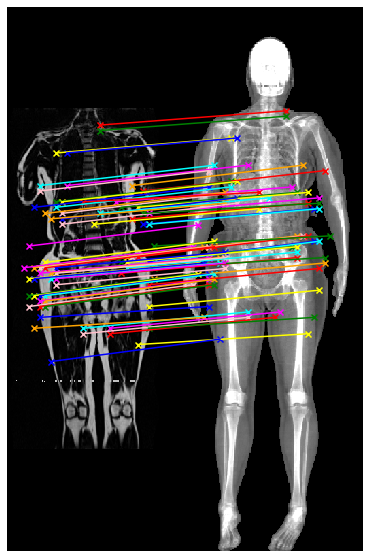

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


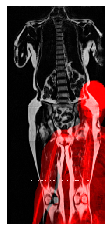

55.83767144305028 0.4046595830983562


NameError: name 'b' is not defined

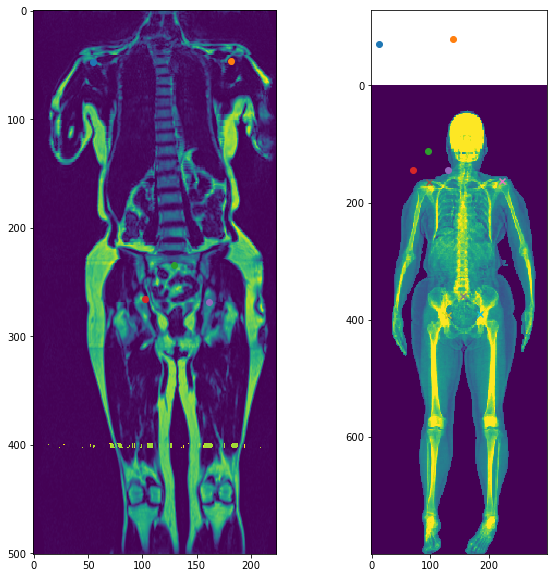

In [3]:
import torch
import math
from gen_utils import *
def resample_point(src_img, tgt_img, point):
    # resample points from one image frame to another
    hs, ws = src_img.size()
    ht, wt = tgt_img.size()
    resampled_point = [None, None]
    resampled_point[0] = np.round(point[0]*ht/hs).astype(np.int)
    resampled_point[1] = np.round(point[1]*wt/ws).astype(np.int)
    return resampled_point

def find_best_rigid(src_pts, tgt_pts, allow_scaling=True):
    src_centroid = np.mean(src_pts,axis=0)
    tgt_centroid = np.mean(tgt_pts,axis=0)
    covar = (src_pts - src_centroid).T@(tgt_pts - tgt_centroid)
    U,S,V = np.linalg.svd(covar)
    R = V@U.T
    pred_exp_norm = np.linalg.norm((R@(src_pts-src_centroid).T).T,axis=1).mean()
    tgt_norm = np.linalg.norm(tgt_pts-tgt_centroid,axis=1).mean()
    if allow_scaling:
        scaling = tgt_norm/pred_exp_norm
    else:
        scaling = 1
    angle = math.atan2(R[1,0], R[0,0])
    t = tgt_centroid - scaling*R@src_centroid
    M = np.concatenate([scaling*R,t[:,None]],axis=1)
    M = np.concatenate([M,np.zeros(3)[None]])
    M[-1,-1] = 1
    angle = angle*180/np.pi
    
    return M, scaling, angle, t

def LowesTest(img1,img2,model1,model2,threshold,use_ransac):
    with torch.no_grad():
        ses1 = F.normalize(model1(img1),dim=1)
        ses2 = F.normalize(model2(img2),dim=1)
    b1, c1, w1, h1 = ses1.size()
    b2, c2, w2, h2 = ses2.size()
    corr4d = torch.bmm(ses1.view(b1,c1,w1*h1).permute(0,2,1),ses2.view(b2,c2,w2*h2)).view(b1, w1, h1, w2, h2)
    corr4d_points = corr4d.view(w1*h1,w2*h2)
    scores, matches = torch.topk(corr4d_points,2)
    good = []
    print(matches)
    for idx in range(len(matches)):
        
        if threshold*scores[idx,0] > scores[idx,1]:
            if resample_point(ses2[0,0], img2[0,0],[matches[idx,0].item()// h2, matches[idx,0].item() % h2]) not in [x[1] for x in good]:
                good.append([resample_point(ses1[0,0], img1[0,0],[idx // h1, idx % h1]), 
                             resample_point(ses2[0,0], img2[0,0],[matches[idx,0].item()// h2, matches[idx,0].item() % h2])])
    good = np.array(good)
    print(len(good))
    if use_ransac:
        M, mask = cv2.findHomography(good[:,0],good[:,1],cv2.RANSAC, 15)
        ransac_good = good[[idx for idx, val in enumerate(mask) if val==1]]
    
        M, scaling, angle, t = find_best_rigid(ransac_good[:,0],ransac_good[:,1],allow_scaling=False)
        return ransac_good, np.linalg.inv(M),ses1,ses2
    else:
        M, scaling, angle, t = find_best_rigid(good[:,0],good[:,1],allow_scaling=False)
        return good, np.linalg.inv(M),ses1,ses2

    
            

ds_idx = 10
122
sample = ds[ds_idx]


good_matches,M,orig_ses1,orig_ses2 = LowesTest(sample['dxa_img'][None], sample['mri_img'][None], dxa_model, mri_model, 0.95,use_ransac=True)

print(torch.Tensor(sample['dxa_img'][0].shape[-2:]).numpy().shape)
diff = ((sample['dxa_img'].shape[-2] - sample['mri_img'].shape[-2]),(sample['dxa_img'].shape[-1] - sample['mri_img'].shape[-1]))

img = F.pad(sample['mri_img'], (0,0,int(np.floor(diff[0]/2)), int(np.ceil(diff[0]/2))))
print(img.shape)
print(sample['mri_img'].shape)
img = torch.cat([img, sample['dxa_img']],axis=-1)
print(img.shape)
plt.figure(figsize=(10,10))
plt.imshow(grayscale(img[0]))
colors=['red','green','yellow','blue','cyan','magenta','orange','pink']
for idx, (dxa_match, mri_match) in enumerate(good_matches):
    plt.scatter(dxa_match[1]+sample['mri_img'].shape[-1], dxa_match[0],c=colors[idx % len(colors)],marker='x')
    plt.scatter(mri_match[1], mri_match[0]+int(np.floor(diff[0]/2)),c=colors[idx % len(colors)],marker='x')
    plt.plot([dxa_match[1]+sample['mri_img'].shape[-1],mri_match[1]], [dxa_match[0],mri_match[0]+int(np.floor(diff[0]/2))],c=colors[idx % len(colors)])

plt.xlim([0,img.shape[-1]])  
plt.axis('off')
plt.savefig(f'lowes_correspondances/sample_{ds_idx}')
plt.show()





new_M = M.copy()
new_M[0,2],new_M[1,2]=new_M[1,2],new_M[0,2]
new_M[0,1],new_M[1,0]=new_M[1,0],new_M[0,1]
img_warp = cv2.warpPerspective(np.array(255*sample['dxa_img'][0]).astype('uint8'),new_M,(sample['mri_img'].shape[-1], sample['mri_img'].shape[-2]))
plt.imshow(red(img_warp/255)+grayscale(sample['mri_img'][0]))
plt.axis('off')
plt.show()

#
plt.figure(figsize=(10,10))

sample['dxa_keypoints'] = ((np.array(sample['dxa_keypoints'])*1/0.911 + np.array([10,0]))).tolist()
tgt_pts = sample['dxa_keypoints']
src_pts = sample['mri_keypoints']
est_tgt_pts = transform_points(src_pts,np.linalg.inv(M))

plt.subplot(121)
plt.imshow(sample['mri_img'][0])
for pt in src_pts:
    plt.scatter(pt[1],pt[0])
plt.subplot(122)
plt.imshow(sample['dxa_img'][0])
for pt in est_tgt_pts:
    plt.scatter(pt[1],pt[0])
for pt in tgt_pts:
    plt.scatter(pt[1],pt[0],marker='x')
errors = np.linalg.norm(tgt_pts - est_tgt_pts, axis=1)*0.22
print(np.mean(errors),np.std(errors))
b

  0%|          | 0/100 [00:00<?, ?it/s]

img1 (800, 300)
[[-4.97489382e-01 -8.92454693e-02  1.57226147e+02]
 [-2.45008622e+00 -4.39837209e-01  7.74431178e+02]
 [-3.16316294e-03 -5.68380618e-04  1.00000000e+00]]
(3, 3)


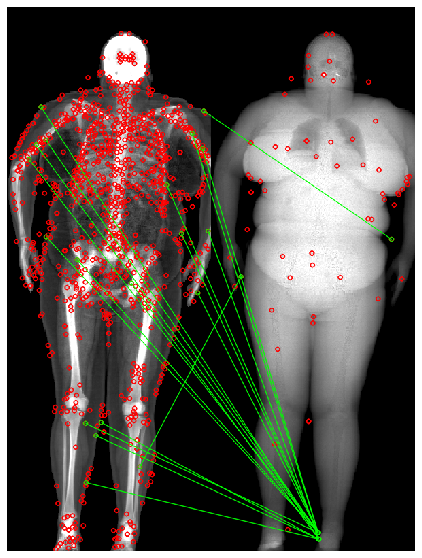

  1%|          | 1/100 [00:06<11:19,  6.86s/it]

img1 (800, 300)
[[ 8.69522093e-01 -3.47861858e-02  1.83204868e+01]
 [-9.36918097e-02  7.83790168e-01  6.25764424e+01]
 [-2.05890162e-04 -1.69628425e-04  1.00000000e+00]]
(3, 3)


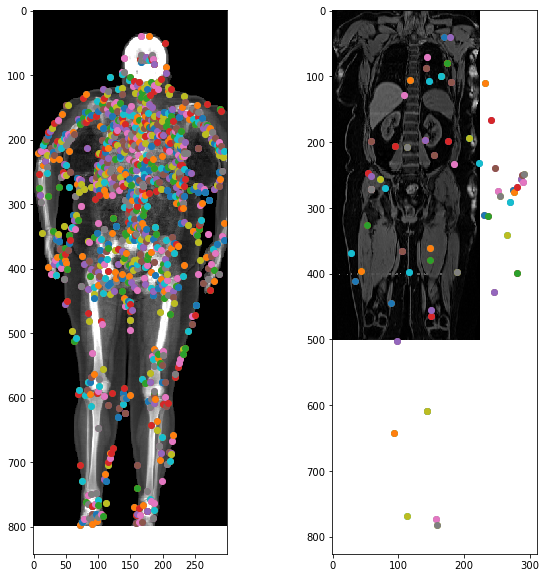

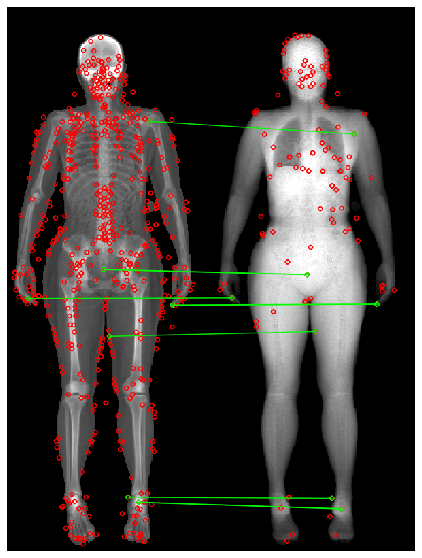

  2%|▏         | 2/100 [00:14<11:20,  6.95s/it]

img1 (800, 300)


  2%|▏         | 2/100 [00:16<13:34,  8.31s/it]


ValueError: operands could not be broadcast together with shapes (1006,128) (1007,128) 

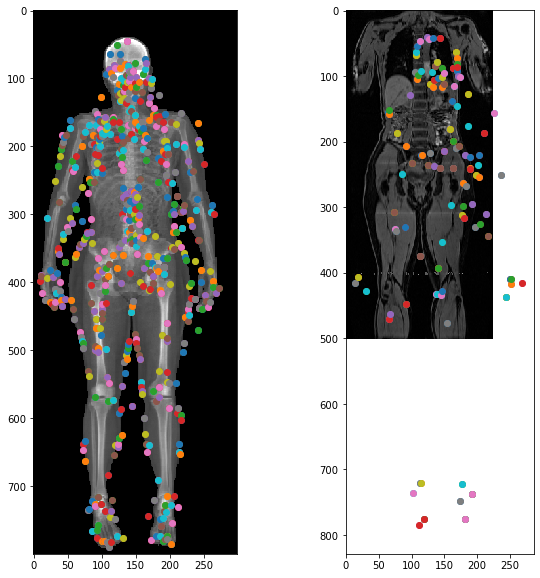

In [49]:
import matplotlib.pyplot as plt
from gen_utils import *
import cv2
def get_SIFT_correspondance(img1, img2, use_ransac, ransac_tolerance):

    sift = cv2.SIFT_create()
    img1 = cv2.cvtColor(np.uint8(np.stack([255*img1]*3,axis=-1)), cv2.COLOR_RGB2GRAY)
    img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    img2 = cv2.cvtColor(np.uint8(np.stack([255*img2]*3,axis=-1)), cv2.COLOR_RGB2GRAY)
    img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    cv2.imwrite('test.png',img1)
    cv2.imwrite('test2.png',img2)
    print('img1', img1.shape)
    kp1_a, des1_a = sift.detectAndCompute(img1,None)
    kp2_a, des2_a = sift.detectAndCompute(img2,None)
    kp1_b, des1_b = sift.detectAndCompute(255-img1,None)
    kp2_b, des2_b = sift.detectAndCompute(255-img2,None)
    
    kp1 = kp1_a + kp1_b
    kp2 = kp2_a + kp2_b
    des1 = des1_a + des1_b
    des2 = des2_a + des2_b
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    #Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good.append([m])
    matches = np.asarray(good)
    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    cv2.imwrite('test.png',img3)
    
    
    if len(matches[:,0]) >= 4:
        src = np.float32([ kp1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
        dst = np.float32([ kp2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 10.0)
    print(H)
    #H = np.array([[0.707106781,0.707106781,200],[-0.707106781,0.707106781,200],[0,0,1]]).astype(np.float32)
    print(H.shape)
    dst = cv2.warpPerspective(img1,H,(img1.shape[1] + img2.shape[1], img2.shape[0]))
    dst[0:img2.shape[0], 50:img2.shape[1]+50] = img2
    #     plt.subplot(122);plt.imshow(dst);plt.title('Warped Image')
    #     plt.show()
    return kp1,des1,kp2,des2,matches,masked





all_errors = []
all_best_poss_errors = []
pbar = tqdm(range(len(ds)))
labels=['left_arm', 'right_arm','spine_base','left_leg','right_leg']
best_scalings = []
for idx in pbar:
    tgt_pixel_spacing = 0.24
    sample = ds[idx]
    if c.USE_EQUAL_RES:
        #sample['dxa_img'] = F.interpolate(sample['dxa_img'][None], scale_factor=1/0.911)[0]
        #sample['target'] = F.interpolate(sample['target'][None], scale_factor=1/0.911)[0]
        tgt_pixel_spacing = tgt_pixel_spacing*0.911
        sample['dxa_keypoints'] = ((np.array(sample['dxa_keypoints'])*1/0.911 + np.array([10,0]))).tolist()

    kps1,des1,kps2,des2,matches,masked=get_SIFT_correspondance(sample['dxa_img'][0],(sample['dxa_img'][1]),True,15)
    draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = masked,
                   flags = 0)
    img3 = cv2.drawMatchesKnn((255*sample['dxa_img'][0].numpy()).astype(np.uint8),kps1,(255*sample['dxa_img'][1].numpy()).astype(np.uint8),kps2,matches,None,**draw_params)
    plt.figure(figsize=(10,10))
    plt.imshow(img3)
    plt.axis('off')
    plt.savefig(f'sift_failures/dxa_bone_to_dxa_tissue_invariant/example_{idx}')
    plt.show()


    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(grayscale(sample['dxa_img'][0]))
    for kp in kps1:
        plt.scatter(*kp.pt)
    plt.subplot(122)
    plt.imshow(grayscale(sample['mri_img'][1]))
    for kp in kps2:
        plt.scatter(*kp.pt)
    if idx > 5:
        break
    

In [ ]:
from registration import resample_point
from matplotlib.patches import Rectangle
import torchvision.transforms.functional as TF
import math
def get_dense_correspondance(img1,img2,enc_model1,enc_model2,use_cuda, upsample_factor,rotation_range=(-2,2),tries=1):
    enc_model1.eval();enc_model2.eval()
    img1=img1[None];img2=img2[None]
    if use_cuda:
        img1 = img1.cuda()
        img2 = img2.cuda()
    with torch.no_grad():
        ses1 = enc_model1(img1)
        ses2 = enc_model2(img2)
        
    if upsample_factor != 1:
        ses1 = F.interpolate(ses1, scale_factor=upsample_factor, mode='bicubic',align_corners=False)
        ses2 = F.interpolate(ses2, scale_factor=upsample_factor, mode='bicubic',align_corners=False)
    angles=[]
    image_indexes=[]
    ses1 = F.normalize(ses1, dim=1)
    ses2 = F.normalize(ses2, dim=1)
    best_score = -9999
    best_angle = 0
    best_idx = None
    for angle in np.linspace(*rotation_range,tries):
        correlate_response = F.conv2d(ses1,TF.rotate(ses2,angle,center=(0,0)))
        max_response, flat_idx = F.max_pool2d_with_indices(correlate_response,(correlate_response.shape[-2:]))
        ses_index = [flat_idx.item()//correlate_response.shape[-1],flat_idx.item()%correlate_response.shape[-1]]
        img_idx = resample_point(ses1[0,0],img1[0,0],ses_index)
        if max_response > best_score:
            best_score = max_response
            best_angle = angle
            best_idx = img_idx

    radians = -angle*3.1419/180
    M = [[np.cos(radians),np.sin(radians),-best_idx[1]],
         [-np.sin(radians),np.cos(radians),-best_idx[0]],
         [0,0,1]]
    
    M = np.array(M)
    return M, best_idx, angle
    
for idx in range(10):
    sample=ds[idx]
    M,img_idx,angle = get_dense_correspondance(sample['dxa_img'],sample['mri_img'],dxa_model,mri_model,False,2, (-1,1),tries=10)
    plt.figure(figsize=(10,10))
#     plt.subplot(121)
#     plt.imshow(grayscale(sample['dxa_img'][0]))
#     plt.gca().add_patch(Rectangle([img_idx[1],img_idx[0]],sample['mri_img'].shape[-1],sample['mri_img'].shape[-2],fc='none',ec='y',angle=angle))
#     plt.subplot(122)
#     plt.imshow(grayscale(sample['mri_img'][0]))
#     plt.show()
    img1=cv2.cvtColor(np.uint8(np.stack([255*sample['dxa_img'][0]]*3,axis=-1)), cv2.COLOR_RGB2GRAY)
    img1=cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    new_M = M.copy(); new_M[1,2],new_M[0,2]=-new_M[0,2],-new_M[1,2]; new_M
    warped_dxa = cv2.warpPerspective(img1,M,(sample['mri_img'].shape[-1], sample['mri_img'].shape[-2]))
#     plt.figure(figsize=(10,10))
#     plt.subplot(121)
#     plt.imshow(grayscale(sample['mri_img'][0]))
#     plt.subplot(122)
#     plt.imshow(warped_dxa)
#     plt.show()

    plt.figure(figsize=(10,10))
    
    
    plt.subplot(131)
    plt.imshow(grayscale(sample['dxa_img'][0]))
    plt.subplot(132)
    plt.imshow(grayscale(sample['mri_img'][0]))
    plt.subplot(133)
    plt.imshow(grayscale(sample['mri_img'][0])+(red(warped_dxa)+blue(warped_dxa))/255)  
    plt.savefig(f'../images/example_registrations_{idx}')

In [ ]:

def PointToPoint(img1,img2,model1,model2,src_keypoints,upsample_factor):
    with torch.no_grad():
        ses1 = F.normalize(model1(img1),dim=1)
        ses2 = F.normalize(model2(img2),dim=1)
    if upsample_factor != 1:
        ses1 = F.interpolate(ses1, scale_factor=upsample_factor,mode='bicubic',align_corners=False)
        ses2 = F.interpolate(ses2, scale_factor=upsample_factor,mode='bicubic', align_corners=False)
        
    b1, c1, w1, h1 = ses1.size()
    b2, c2, w2, h2 = ses2.size()
    corr4d = torch.bmm(ses1.view(b1,c1,w1*h1).permute(0,2,1),ses2.view(b2,c2,w2*h2)).view(b1, w1, h1, w2, h2)
    corr4d_points = corr4d.view(w1*h1,w2*h2)
    tgt_pts = []
    for point in src_keypoints:
        print(point)
        ses2_pt = resample_point(img2[0,0],ses2[0,0],point)
        corrs = corr4d[0,:,:,ses2_pt[0],ses2_pt[1]].view(-1)
        ses1_pt = [corrs.argmax().item()//h1, corrs.argmax().item()%h1]
        plt.figure(figsize=(10,10))
        plt.imshow(F.softmax(corrs.view(w1, h1)))
        plt.scatter(ses1_pt[1],ses1_pt[0],color='r',marker='x')
        plt.show()
       
        ses1_pt = [corrs.argmax().item()//h1, corrs.argmax().item()%h1]
        print(ses1_pt)
        tgt_pt = resample_point(ses1[0,0],img1[0,0],ses1_pt)
        tgt_pts.append(tgt_pt)
    return tgt_pts

            


sample = ds[3]

src_pts = sample['mri_keypoints']
sample['dxa_keypoints'] = ((np.array(sample['dxa_keypoints'])*1/0.911 + np.array([10,0]))).tolist()

tgt_pts = sample['dxa_keypoints']

est_tgt_pts = PointToPoint(sample['dxa_img'][None], sample['mri_img'][None], dxa_model, mri_model, sample['mri_keypoints'],1)
print(est_tgt_pts)
plt.subplot(121)
c = ['red','blue','green','yellow','pink']

plt.imshow(sample['mri_img'][0])
for idx, pt in enumerate(src_pts):
    plt.scatter(pt[1],pt[0],c=c[idx])
plt.subplot(122)
plt.imshow(sample['dxa_img'][0])
for idx, pt in enumerate(tgt_pts):
    plt.scatter(pt[1],pt[0],c=c[idx])
for idx, pt in enumerate(est_tgt_pts):
    plt.scatter(pt[1],pt[0],marker='x',c=c[idx])

In [ ]:
class config():
    TRAINING_AUGMENTATION=False
    DATASET_ROOT = '/scratch/shared/beegfs/rhydian/UKBiobank'
    MODEL_LOAD_PATH = '/users/rhydian/self-supervised-project/model_weights/SSECEncodersHighRes2'
#     MODEL_LOAD_PATH = '/users/rhydian/self-supervised-project/model_weights/SSECEncodersBothBoth'
    USE_EQUAL_RES = True
    # ENCODER_TYPE = HighResVGGEncoder
    ENCODER_TYPE = HighResVGGEncoder
    EMBEDDING_SIZE = 128
    USE_CUDA = False 
    UPSAMPLE_FACTOR = 2 # amount feature maps scaled up for subpixel accuracy
    USE_CYCLIC = True # use cyclic point correlation
    USE_RANSAC = True
    RANSAC_TOLERANCE = 15
    GRID_RES = 1
    ALLOW_SCALING = False
    NUM_DISCRIM_POINTS = int(200*GRID_RES**2) # number of correlating pairs to find
    METHOD = 'MATCH_KEYPOINT' # from DENSE, SIFT, MATCH_KEYPOINT
    assert METHOD in ['MATCH_KEYPOINT','DENSE','SIFT']


def set_up():
    global c
    ds  = KeypointAlignmentDataset()
    dxa_model, mri_model, val_stats, epochs = load_models(c.ENCODER_TYPE, c.EMBEDDING_SIZE, 
                                                          c.MODEL_LOAD_PATH, c.USE_CUDA, SINGLE_MRI=0, SINGLE_DXA=0 )
    return ds, dxa_model, mri_model, val_stats, epochs

c = config()
ds, dxa_model, mri_model, val_stats, epochs = set_up()

In [ ]:
sample=ds[2]

dxa_pt = [200,120]
TEMP=4
dxa_model.eval()
mri_model.eval()

ses1 = F.normalize(dxa_model(sample['dxa_img'][None]),dim=1)
ses2 = F.normalize(mri_model(sample['mri_img'][None]),dim=1)
b1, c1, w1, h1 = ses1.size()
b2, c2, w2, h2 = ses2.size()
corr4d = torch.bmm(ses1.view(b1,c1,w1*h1).permute(0,2,1),ses2.view(b2,c2,w2*h2)).view(b1, w1, h1, w2, h2)
ses1_pt = resample_point(sample['dxa_img'][0],ses1[0,0],dxa_pt)
corr_map = corr4d.squeeze(0)[ses1_pt[0],ses1_pt[1]].view(-1).view(w2, h2)
if True:
    corr_map = F.softmax(corr_map.view(1,-1)/TEMP,dim=-1).view(w2,h2)
corr_map = F.interpolate(corr_map[None,None],[sample['mri_img'].shape[-2],sample['mri_img'].shape[-1]]).detach()[0,0]

print(corr_map.shape)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(sample['dxa_img'][0],cmap='gray')
plt.scatter(dxa_pt[1],dxa_pt[0])
plt.subplot(122)

plt.imshow(grayscale(sample['mri_img'][0])+red((corr_map-corr_map.min())/(corr_map.max()-corr_map.min())))

In [ ]:
print(corr4d)